# Assignment 2
### Predict stock market price for TESLA


# Chosing an algorithm

Document your findings in a file (3-5 lines) on why you chose this algorithm.

# Imports

In [3079]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Reading the data

In [3080]:
# We read the data from the csv file
data = pd.read_csv('data/TESLA.csv')

# We call info() to check if there are any null values or object types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3357 entries, 0 to 3356
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3357 non-null   object 
 1   Open       3357 non-null   float64
 2   High       3357 non-null   float64
 3   Low        3357 non-null   float64
 4   Close      3357 non-null   float64
 5   Adj Close  3357 non-null   float64
 6   Volume     3357 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 183.7+ KB


In [3081]:
# We transform the Date column to datetime type
data['Date'] = pd.to_datetime(data['Date'])

In [3082]:
# Describe to check range of values
data.describe()

,Date,Open,High,Low,Close,Adj Close,Volume
count,3357,3357.000000,3357.000000,3357.000000,3357.000000,3357.000000,3.357000e+03
mean,2017-02-26 05:51:18.820375296,68.372233,69.892698,66.736911,68.350852,68.350852,9.650271e+07
min,2010-06-29 00:00:00,1.076000,1.108667,0.998667,1.053333,1.053333,1.777500e+06
25%,2013-10-28 00:00:00,10.166667,10.498667,9.917333,10.162667,10.162667,4.549350e+07
50%,2017-02-28 00:00:00,16.803333,17.049334,16.566668,16.809334,16.809334,8.041650e+07
75%,2020-06-29 00:00:00,67.456665,68.498665,66.297997,68.336670,68.336670,1.230810e+08
max,2023-10-27 00:00:00,411.470001,414.496674,405.666656,409.970001,409.970001,9.140820e+08
std,NaN,100.435123,102.699392,97.945596,100.352800,100.352800,8.048337e+07


We need to plot the data to get a better understanding of what is going on

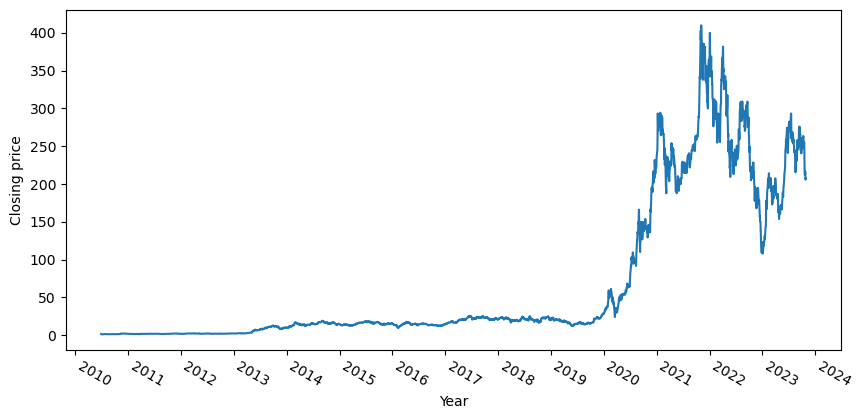

In [3083]:
# We create a plot showing the closing price of Tesla stock labeled by year
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(data["Date"], data['Close'],)
ax.set_xlabel('Year')
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.set_ylabel('Closing price')
fig.autofmt_xdate(rotation=-30, ha='left')
plt.show()

From the plot we can see that the value skyrocketed in 2020. We might need to keep this in mind when training our model.

# Preparing the data

In [3084]:
# We create a new dataframe with only the Date and Close columns
df = data[['Date', 'Close']].copy()

# We separate the Date column into Year, Month, day and DayOfWeek columns to use them as features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Day_of_week'] = df['Date'].dt.dayofweek

# Set the Date column as the index
df.set_index('Date', inplace=True, drop=True)

# Move Column Close to the end
df = df[[c for c in df if c not in ['Close']] + ['Close']]

# # We create a new column with the closing price of the next day
# df['Close_next_day'] = df['Close'].shift(-1)

# # Crate a baseline column with a naive guess. The closing price of the current day
# df['naive_guess'] = df['Close']

# Cut of at the end of 2020
# df = df[:'2020-12-31']

# Cut of at the end of 2020
df = df[:'2020-12-31']

df.info()

df.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2647 entries, 2010-06-29 to 2020-12-31
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Year         2647 non-null   int32  
 1   Month        2647 non-null   int32  
 2   Day          2647 non-null   int32  
 3   Day_of_week  2647 non-null   int32  
 4   Close        2647 non-null   float64
dtypes: float64(1), int32(4)
memory usage: 82.7 KB


,Year,Month,Day,Day_of_week,Close
Date,,,,,
2020-12-24,2020,12,24,3,220.589996
2020-12-28,2020,12,28,0,221.229996
2020-12-29,2020,12,29,1,221.996674
2020-12-30,2020,12,30,2,231.593338
2020-12-31,2020,12,31,3,235.223328


In [3085]:


# Split the dataframe into features X and target Y
X = df.drop(['Close'], axis=1)
Y = df['Close']

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.1, random_state=1)

# We create a GradientBoostingRegressor model with default parameters
model = GradientBoostingRegressor()

# We fit the model to the training data
model.fit(x_train, y_train)

GradientBoostingRegressor()

In [3086]:
# We calculate the mean squared error of the model
mse = mean_squared_error(y_test, model.predict(x_test))
print("The mean squared error is: {:.4f}".format(mse))

The mean squared error is: 13.2228


# Plot feature importance

<Axes: >

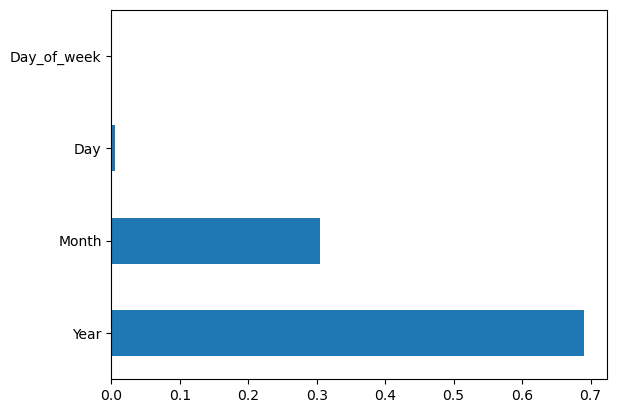

In [3087]:
# Lets plot the feature importances of the model to see which features are the most important
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances.plot(kind='barh')

# Hyperparameter tuning

In order to improve the performance of the model we need to tune the hyperparameters. We will use the RandomizedSearchCV to find the best hyperparameters.

In [3095]:
# We create a new GradientBoostingRegressor model with default parameters
model_new = GradientBoostingRegressor()

# We create a dictionary with the parameters we want to test
distrubutions = {
    "n_estimators": [100, 250, 500, 750, 1000],
    "max_depth": [2, 3, 4, 5, 6],
    "min_samples_split": [2, 3, 4, 5],
    "learning_rate": [0.001, 0.01, 0.1, 1],
    "loss": ["squared_error", "absolute_error", "huber", "quantile"],
}

# Create a RandomizedSearchCV object with the model and the distributions
search = RandomizedSearchCV(
    model_new,
    param_distributions=distrubutions,
    n_iter=10,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    cv=5,
)

# Best params from running the RandomizedSearchCV above with iterations=250 (MSE: 5)
# {'n_estimators': 1000,
#  'min_samples_split': 5,
#  'max_depth': 6,
#  'loss': 'squared_error',
#  'learning_rate': 0.01}

# Fit the model with x and y train sets from earlier
search.fit(x_train, y_train)
model_new = search.best_estimator_ # Get the best model
best_params = search.best_params_ # Get the best parameters
best_params

In [3097]:
# We calculate the mean squared error of the tuned model
mse_new = mean_squared_error(y_test, model_new.predict(x_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse_new))

The mean squared error (MSE) on test set: 5.0786


In [3098]:
# Lets look at the improvement in MSE 
print("The mean squared error (MSE) improvement: {:.2f}%".format(
    (mse - mse_new) / mse * 100))

The mean squared error (MSE) improvement: 61.59%


In [3103]:
# Make a prediction for the closing price of the next day 28.10.2023
# We create a new dataframe with the date 28.10.2023
date = "2023-10-28"

future = pd.DataFrame(
    data={'Date': ['2023-10-28']},
    columns=['Date'],
)

# We transform the Date column to datetime type
future['Date'] = pd.to_datetime(future['Date'])

# We separate the Date column into Year, Month, day and DayOfWeek columns to use them as features
future['Year'] = future['Date'].dt.year
future['Month'] = future['Date'].dt.month
future['Day'] = future['Date'].dt.day
future['Day_of_week'] = future['Date'].dt.dayofweek

# Set the Date column as the index
future.set_index('Date', inplace=True, drop=True)

# Make a prediction for the closing price of the next day 28.20.2023
prediction = model_new.predict(future)

# Print the prediction
print("The predicted closing price for {} is: {:.2f}".format(prediction[0]))

The predicted closing price for 28.10.2023 is: 134.27


# Further improvements

We created a model that predicts the closing price of Tesla stock based only on features derived from the date. Ideally we would like to use more features to improve the performance of the model. We would also be more likely to get a meaningful result if we turned this into a classification problem to only predict if the price will go up or down, based on a set of features and a series of historical data.